# Import library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import  cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, plot_confusion_matrix#

# Data prepareration

In [2]:
#import data
df = pd.read_excel('D:\BD521\Project\Material\project_data.xlsx')
lounge_type = pd.read_excel('lounge_type.xlsx')

In [3]:
df.head()

,InvoiceNumber,Station,PaxDate,PaxFlight,Class,FQTV,Lounge,Nationality,GuestFlight,GuestDate,Amount,PaxApproval,GuestApproval
0,052020CA00068,PVG,23/5/2020,CA935,C,2220.0,CPVG71,NaN,CA935,23/5/2020,1,NaN,Approved
1,052020CA00069,PVG,16/5/2020,CA935,Y,2220.0,CPVG71,NaN,NaN,NaN,1,Approved,NaN
2,052020CA00070,PVG,16/5/2020,CA935,Y,2220.0,CPVG71,NaN,NaN,NaN,1,Approved,NaN
3,052020CA00071,PVG,9/5/2020,CA935,Y,2220.0,CPVG71,NaN,NaN,NaN,1,Approved,NaN
4,052020CA00072,PVG,23/5/2020,CA935,Y,2220.0,CPVG71,NaN,NaN,NaN,1,Approved,NaN


In [4]:
lounge_type.head()

,Owner,Lounge,LoungeType,PartnerType
0,OZ,CJUID,Business Lounge,Star Alliance
1,OZ,ICNC1,Business Lounge,Star Alliance
2,OZ,GMPIN,Business Lounge,Star Alliance
3,OZ,ICNC2,Business Lounge,Star Alliance
4,OZ,ICNC3,Business Lounge,Star Alliance


In [2]:
#transform FQTV to Tier
df['FQTV'] = df['FQTV'].astype(str).str[0:4]
Tier = {'3330':'HON', '2220':'SEN', '9922':'FTL', '9920':'PPC', '9999':'TC'}
df['Tier'] = df['FQTV'].map(Tier)
df.loc[df['Tier'].isna(),['Tier']]='NO M&M'

#Edit format
Class = {'F':'F', 'O':'F', 'A':'F', 'C':'C', 'Y':'Y', 'M':'Y', 'E':'Y'}
df['Class'] = df['Class'].map(Class)

#transform to binominal
df['LufthansaOperating'] = np.where(df['PaxFlight'].str[0:2]=='LH', 1, 0)

#transform Nationality to Residence
Residence = {'DE':'Germany', 'CH':'Germany Border', 'BE':'Germany Border', 'AT':'Germany Border','PL':'Germany Border'}
df['Residence'] = df['Nationality'].map(Residence)
df.loc[(df['Residence'].isna()) & (df['Nationality'].notna()), 'Residence'] = 'Not Germany Border'
df.loc[(df['Residence'].isna()) & (df['Tier']!='NO M&M'), 'Residence'] = 'Not Specified'
df.loc[(df['Residence'].isna()) & (df['Tier']=='NO M&M'), 'Residence'] = 'No Record'

#some invoice contain 2 customer, transform to single customer  in each line
Guest = df.loc[df['Amount']==2]
Guest['InvoiceType'] = 'Guest'
df.loc[(df['Amount']==1) & (df['GuestFlight'].isna()), 'InvoiceType'] = 'Passenger'
df.loc[df['Amount']==1 & df['GuestFlight'].notna(), 'InvoiceType'] = 'Guest'
df.loc[df['Amount']==2, 'InvoiceType'] = 'Passenger'
df = df.append(Guest, ignore_index=True)
df['Approval'] = np.where(df['InvoiceType']=='Passenger', df['PaxApproval'], df['GuestApproval'])

#join 2 dataset
df = pd.merge(df, lounge_type, how="left", on='Lounge')

df.head()

<ipython-input-2-262d6b95e0e0>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Guest['InvoiceType'] = 'Guest'


,InvoiceNumber,Station,PaxDate,PaxFlight,Class,FQTV,Lounge,Nationality,GuestFlight,GuestDate,...,PaxApproval,GuestApproval,Tier,LufthansaOperating,Residence,InvoiceType,Approval,Owner,LoungeType,PartnerType
0,052020CA00068,PVG,23/5/2020,CA935,C,2220,CPVG71,NaN,CA935,23/5/2020,...,NaN,Approved,SEN,0,Not Specified,Guest,Approved,CA,Business Lounge,Star Alliance
1,052020CA00069,PVG,16/5/2020,CA935,Y,2220,CPVG71,NaN,NaN,NaN,...,Approved,NaN,SEN,0,Not Specified,Passenger,Approved,CA,Business Lounge,Star Alliance
2,052020CA00070,PVG,16/5/2020,CA935,Y,2220,CPVG71,NaN,NaN,NaN,...,Approved,NaN,SEN,0,Not Specified,Passenger,Approved,CA,Business Lounge,Star Alliance
3,052020CA00071,PVG,9/5/2020,CA935,Y,2220,CPVG71,NaN,NaN,NaN,...,Approved,NaN,SEN,0,Not Specified,Passenger,Approved,CA,Business Lounge,Star Alliance
4,052020CA00072,PVG,23/5/2020,CA935,Y,2220,CPVG71,NaN,NaN,NaN,...,Approved,NaN,SEN,0,Not Specified,Passenger,Approved,CA,Business Lounge,Star Alliance


In [3]:
#feature selection
feature_cols = df[['Class', 'Tier', 'LufthansaOperating', 'Residence', 'InvoiceType', 'LoungeType', 'PartnerType']]

feature_cols.head()

,Class,Tier,LufthansaOperating,Residence,InvoiceType,LoungeType,PartnerType
0,C,SEN,0,Not Specified,Guest,Business Lounge,Star Alliance
1,Y,SEN,0,Not Specified,Passenger,Business Lounge,Star Alliance
2,Y,SEN,0,Not Specified,Passenger,Business Lounge,Star Alliance
3,Y,SEN,0,Not Specified,Passenger,Business Lounge,Star Alliance
4,Y,SEN,0,Not Specified,Passenger,Business Lounge,Star Alliance


In [4]:
#transform to dummy data for decision tree classification
feature_cols_dum = pd.get_dummies(feature_cols)

feature_cols_dum.head()

,LufthansaOperating,Class_C,Class_F,Class_Y,Tier_FTL,Tier_HON,Tier_NO M&M,Tier_PPC,Tier_SEN,Tier_TC,...,Residence_Not Specified,InvoiceType_Guest,InvoiceType_Passenger,LoungeType_Business Lounge,LoungeType_First Lounge,LoungeType_Gold Lounge,LoungeType_Miles&More Lounge,PartnerType_Lufthansa Group,PartnerType_Miles&More Member,PartnerType_Star Alliance
0,0,1,0,0,0,0,0,0,1,0,...,1,1,0,1,0,0,0,0,0,1
1,0,0,0,1,0,0,0,0,1,0,...,1,0,1,1,0,0,0,0,0,1
2,0,0,0,1,0,0,0,0,1,0,...,1,0,1,1,0,0,0,0,0,1
3,0,0,0,1,0,0,0,0,1,0,...,1,0,1,1,0,0,0,0,0,1
4,0,0,0,1,0,0,0,0,1,0,...,1,0,1,1,0,0,0,0,0,1


# Modeling

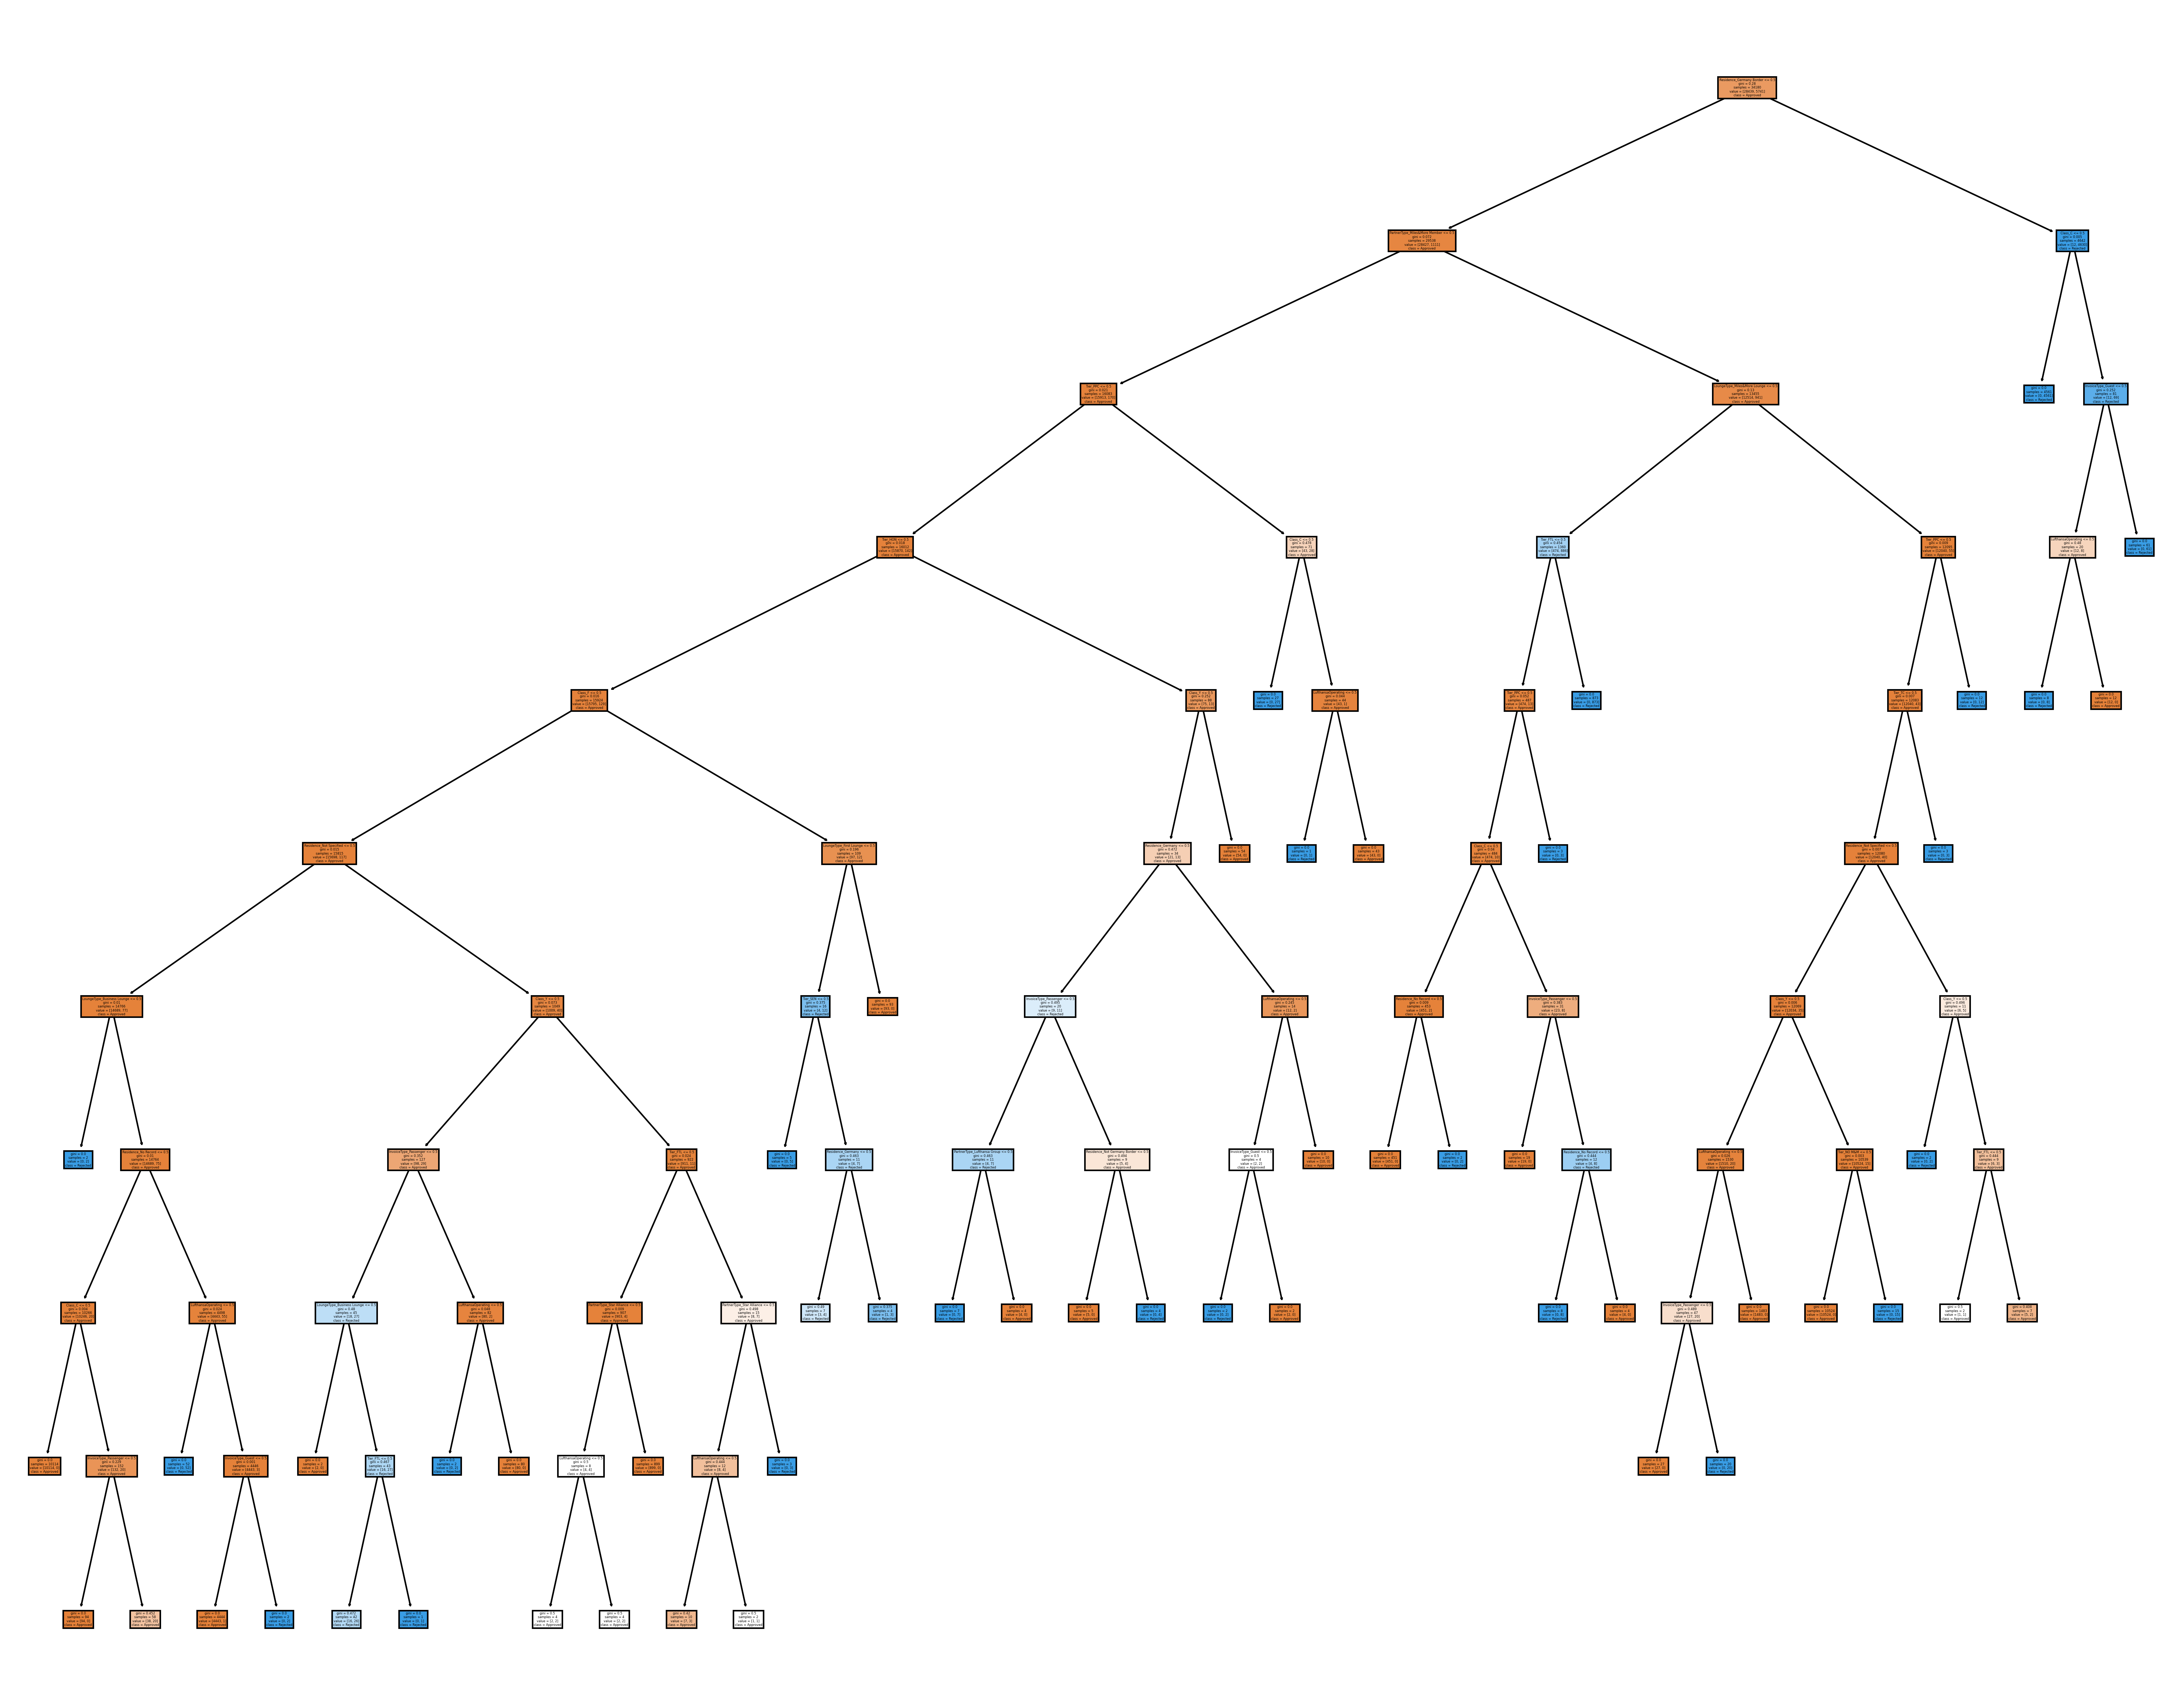

In [34]:
X = feature_cols_dum
y = df['Approval']

clf = tree.DecisionTreeClassifier(max_depth=10)
clf = clf.fit(X, y)

plt.figure(figsize=(25,20), dpi=300)
decision_tree = tree.plot_tree(clf,
                              feature_names=list(feature_cols_dum.columns),
                              class_names=['Approved', 'Rejected'],
                              filled=True)

# Evaluation

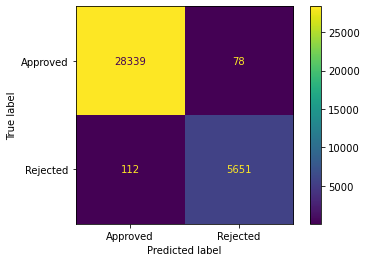

In [6]:
cross_val_predict = cross_val_predict(clf, X, y, cv=10)
plot_confusion_matrix(clf, X, cross_val_predict)

In [7]:
print(classification_report(y, cross_val_predict))

              precision    recall  f1-score   support

    Approved       1.00      1.00      1.00     28439
    Rejected       0.98      0.99      0.98      5741

    accuracy                           0.99     34180
   macro avg       0.99      0.99      0.99     34180
weighted avg       0.99      0.99      0.99     34180

